In [1]:
# Improt the necessary libraries
import itertools
import xarray as xr
import rasterio
import pandas as pd
import geopandas as gpd
import rioxarray
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm as colormap
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.patches as mpatches
from sklearn.metrics import confusion_matrix
import numpy as np

In [2]:
# Filepaths

WTE_FOLDER = "/mnt/drive/AI4EBV/INPUTS/WTE/"
WTE_GLOBAL = "WTE1778.tif"

# Wte table

WTE_TABLE = WTE_FOLDER + "Tables/Realm_WE_attribute_Table_DraftSort.csv"

# South Tyrol shapefile

ST_SHP = "/mnt/drive/AI4EBV/BOUNDARIES/ST.shp"

# Output desired UTM Projection
# It is estimated automatically based on the provided shapefile. Needs to be tested in details. New PROJ version required >7
OUTPUT_CRS = "EPSG:32632"

Read the input WTE layer

In [3]:
wte_global = xr.open_rasterio(WTE_FOLDER + WTE_GLOBAL)
wte_global

<xarray.DataArray (band: 1, y: 3535, x: 6358)>
[22475530 values with dtype=uint32]
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 50.1 50.1 50.1 50.1 50.1 ... 42.17 42.17 42.17 42.17
  * x        (x) float64 3.643 3.645 3.647 3.649 ... 17.91 17.91 17.92 17.92
Attributes:
    transform:      (0.0022457989999999997, 0.0, 3.64154024832649, 0.0, -0.00...
    crs:            +init=epsg:4326
    res:            (0.0022457989999999997, 0.0022457989999999997)
    is_tiled:       0
    nodatavals:     (0.0,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area
    DataType:       Generic

Read the input shapefile

In [4]:
df = gpd.read_file(ST_SHP)
df

,COD_REG,COD_PRO,NOME_PRO,SHAPE_Leng,SHAPE_Area,geometry
0,4,21,BOLZANO/BOZEN,664283.497457,7.397682e+09,"POLYGON ((743472.190 5219940.300, 743499.120 5..."


In [5]:
df4326 = df.to_crs(4326)

In [6]:
df_buffer = df4326.copy()

In [7]:
delta = 0.1
minX = df_buffer.geometry.bounds['minx'] - delta
minY = df_buffer.geometry.bounds['miny'] - delta
maxX = df_buffer.geometry.bounds['maxx'] + delta
maxY = df_buffer.geometry.bounds['maxy'] + delta

In [8]:
wte_table = pd.read_csv(WTE_TABLE, sep=';')
wte_table

,RealmWE_ID,WE_ID,Realm_ID,RealmClass,LF_Class,MoistClass,TempClass,LC_Class,Realm_Name,LF_Name,LC_Name,Temp_Name,Moist_Name,Temp_Moist,WEcosystm,RWEcosystm,LandC_Type,Code
0,1005,5,1000,1,1,3,6,6,Afrotropic,Mountains,Sparsley or Non vegetated,Polar,Moist,Polar Moist,Polar Moist Sparsley or Non vegetated on Mount...,Afrotropic Polar Moist Sparsley or Non vegetat...,Natural,6316
1,1010,10,1000,1,3,3,6,6,Afrotropic,Tablelands,Sparsley or Non vegetated,Polar,Moist,Polar Moist,Polar Moist Sparsley or Non vegetated on Table...,Afrotropic Polar Moist Sparsley or Non vegetat...,Natural,6336
2,1016,16,1000,1,2,3,6,6,Afrotropic,Hills,Sparsley or Non vegetated,Polar,Moist,Polar Moist,Polar Moist Sparsley or Non vegetated on Hills,Afrotropic Polar Moist Sparsley or Non vegetat...,Natural,6326
3,1018,18,1000,1,1,3,6,4,Afrotropic,Mountains,Grassland,Polar,Moist,Polar Moist,Polar Moist Grassland on Mountains,Afrotropic Polar Moist Grassland on Mountains,Natural,6314
4,1024,24,1000,1,3,3,6,2,Afrotropic,Tablelands,Shrubland,Polar,Moist,Polar Moist,Polar Moist Shrubland on Tablelands,Afrotropic Polar Moist Shrubland on Tablelands,Natural,6332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1776,8399,399,8000,8,1,3,3,8,Palearctic,Mountains,Snow and Ice,Warm Temperate,Moist,Warm Temperate Moist,Warm Temperate Moist Snow and Ice on Mountains,Palearctic Warm Temperate Moist Snow and Ice o...,Natural,3318
1777,8400,400,8000,8,3,1,4,3,Palearctic,Tablelands,Forest,Sub Tropical,Desert,Sub Tropical Desert,Sub Tropical Desert Forest on Tablelands,Palearctic Sub Tropical Desert Forest on Table...,Natural,4133
1778,8406,406,8000,8,2,1,5,3,Palearctic,Hills,Forest,Tropical,Desert,Tropical Desert,Tropical Desert Forest on Hills,Palearctic Tropical Desert Forest on Hills,Natural,5123
1779,8412,412,8000,8,3,1,5,2,Palearctic,Tablelands,Shrubland,Tropical,Desert,Tropical Desert,Tropical Desert Shrubland on Tablelands,Palearctic Tropical Desert Shrubland on Tablel...,Natural,5132


# Landform

In [9]:
LANDFORM_FOLDER = "/mnt/drive/AI4EBV/INPUTS/LANDFORM/"

SRTM_HM   = LANDFORM_FOLDER + "SRTM_ST_EPSG3035_LAEA-EUROPE_250m_WTE_LF.tif"
MERIT_HM  = LANDFORM_FOLDER + "MERIT_ST_EPSG3035_LAEA-EUROPE_250m_WTE_LF.tif"

## WTE Landform Layer

In [10]:
wte_clipped = wte_global.rio.clip_box(minx=minX,miny=minY,maxx=maxX,maxy=maxY).astype(float)
max_value = wte_clipped.max().values
while(max_value>4):
    LFValue = wte_table.loc[wte_table['RealmWE_ID']==max_value]['LF_Class']
    if len(LFValue) != 0:
        wte_clipped = wte_clipped.where(wte_clipped!=max_value).fillna(int(LFValue))
    else:
        break
    max_value = wte_clipped.max().values
wte_clipped = wte_clipped.where(wte_clipped!=wte_clipped.attrs["_FillValue"])
wte_clipped = wte_clipped.where(wte_clipped!=7)
wte_clipped.attrs["_FillValue"] = np.nan

Define colors and labels for plotting:

In [11]:
landform_cmap = {'Mountains':"#897044",'Hills':"#70A800",'Plains':"#FF73DF",'Tablelands':"#FFFFBE"}
landforms     = ['Mountains','Hills','Plains','Tablelands']

legend = []
for i,x in enumerate(landforms):
    color = landform_cmap[x]
    legend.append(mpatches.Patch(color=color,label=x))
        
colors_diff = ["#00375D","#0000CC","#00CCCC","#E0E0E0","#FFAA00","#CC0000","#660000"]
labels_diff = ["-3 zones","-2 zones","-1 zone","same zone","+1 zone","+2 zones","+3 zones"]
legend_diff = []
for i,x in enumerate(labels_diff):
    legend_diff.append(mpatches.Patch(color=colors_diff[i],label=x))

Create cmap for landform layer

In [12]:
cmap_landform = ListedColormap(["#897044","#70A800","#FF73DF","#FFFFBE"])

Create cmap for difference layer

In [13]:
diff_cmap = ListedColormap(["#00375D","#0000CC","#00CCCC","#E0E0E0","#FFAA00","#CC0000","#660000"])

Reproject to the desired UTM projection:

In [14]:
# wte_lf_UTM = wte_clipped.rio.reproject(OUTPUT_CRS,resolution=250, resampling=0) # Nearest neighbor
wte_lf_UTM = wte_clipped.rio.reproject(wte_clipped.rio.estimate_utm_crs(),resolution=250, resampling=6) # New Proj required
wte_lf_UTM = wte_lf_UTM.rio.clip(df.geometry, drop=True)

[]

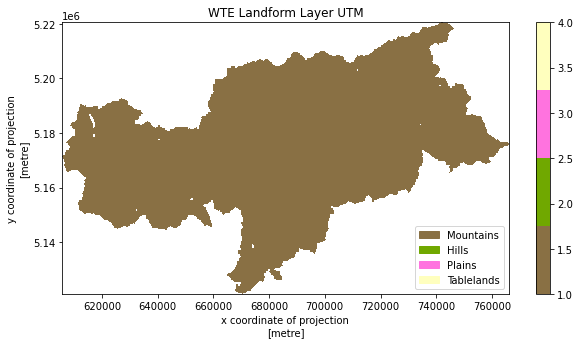

In [15]:
fig, ax = plt.subplots(figsize=(10,5))
fig = wte_lf_UTM[0].plot.imshow(ax=ax,cmap=cmap_landform,vmax=4, vmin=1)
ax.set_title("WTE Landform Layer UTM")
ax.legend(handles=legend,loc='lower right')
ax.margins(10)
plt.plot()

In [16]:
wte_lf_UTM[0].to_netcdf("wte_lf_UTM_ST.nc")

## SRTM

In [17]:
SRTM_HM   = LANDFORM_FOLDER + "SRTM_ST_EPSG3035_LAEA-EUROPE_250m_WTE_LF.tif"

In [18]:
srtm_landform = xr.open_rasterio(SRTM_HM)

In [19]:
df3035 = df.to_crs(3035)

In [20]:
df_buffer = df3035.copy()

In [21]:
delta = 50000
minX = df_buffer.geometry.bounds['minx'] - delta
minY = df_buffer.geometry.bounds['miny'] - delta
maxX = df_buffer.geometry.bounds['maxx'] + delta
maxY = df_buffer.geometry.bounds['maxy'] + delta

In [22]:
srtm_landform_clipped = srtm_landform.rio.clip_box(minx=minX,miny=minY,maxx=maxX,maxy=maxY)
srtm_landform_clipped = srtm_landform_clipped.where(srtm_landform_clipped!=srtm_landform_clipped.attrs["_FillValue"])
srtm_landform_clipped.attrs["_FillValue"] = np.nan

Reprojection to 250m in UTM with mode interpolation

In [23]:
srtm_landform_clipped = srtm_landform_clipped.rio.reproject_match(wte_lf_UTM,6)
srtm_landform_clipped = srtm_landform_clipped.rio.clip(df.geometry, drop=True)
srtm_landform_clipped = srtm_landform_clipped.where(srtm_landform_clipped!=srtm_landform_clipped.attrs["_FillValue"])
srtm_landform_clipped.attrs["_FillValue"] = np.nan

[]

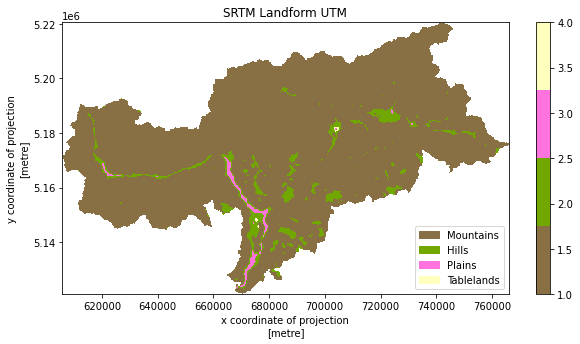

In [24]:
fig, ax = plt.subplots(figsize=(10,5))
fig = srtm_landform_clipped[0].plot.imshow(ax=ax,cmap=cmap_landform,vmax=4, vmin=1)
ax.set_title("SRTM Landform UTM")
ax.legend(handles=legend,loc='lower right')
ax.margins(10)
plt.plot()

In [25]:
# srtm_landform_clipped[0].to_netcdf("srtm_to_wte_lf_UTM_ST.nc")

Combine the NaN masks and mask the data to avoid not overlapping pixels due to reprojection:

In [26]:
na_mask = np.bitwise_not(np.bitwise_or(xr.ufuncs.isnan(wte_lf_UTM),xr.ufuncs.isnan(srtm_landform_clipped)))
wte_lf_UTM_masked_srtm = wte_lf_UTM.where(na_mask)
srtm_to_wte_UTM_masked = srtm_landform_clipped.where(na_mask)

Now that we have both moisture layers with the same class scheme and projection we can compute the difference:

In [27]:
wte_srtm_diff = wte_lf_UTM_masked_srtm - srtm_to_wte_UTM_masked

[]

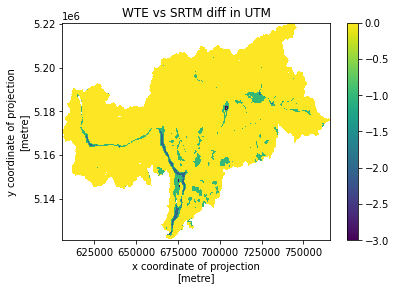

In [28]:
fig, ax = plt.subplots()
wte_srtm_diff[0].plot.imshow(ax=ax)
ax.set_title("WTE vs SRTM diff in UTM")
plt.plot()

## MERIT

In [29]:
MERIT_HM  = LANDFORM_FOLDER + "MERIT_ST_EPSG3035_LAEA-EUROPE_250m_WTE_LF.tif"

In [30]:
merit_landform = xr.open_rasterio(MERIT_HM)
merit_landform

<xarray.DataArray (band: 1, y: 394, x: 642)>
[252948 values with dtype=uint16]
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 2.667e+06 2.666e+06 2.666e+06 ... 2.569e+06 2.568e+06
  * x        (x) float64 4.35e+06 4.351e+06 4.351e+06 ... 4.51e+06 4.511e+06
Attributes:
    transform:      (250.0, 0.0, 4350234.580151736, 0.0, -250.0, 2666796.2087...
    crs:            +init=epsg:3035
    res:            (250.0, 250.0)
    is_tiled:       0
    nodatavals:     (255.0,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area

In [31]:
merit_landform_clipped = merit_landform.rio.clip_box(minx=minX,miny=minY,maxx=maxX,maxy=maxY)
merit_landform_clipped = merit_landform_clipped.where(merit_landform_clipped!=merit_landform_clipped.attrs["_FillValue"])
merit_landform_clipped.attrs["_FillValue"] = np.nan

Reprojection to 250m in UTM with mode interpolation

In [32]:
merit_landform_clipped = merit_landform_clipped.rio.reproject_match(wte_lf_UTM,6)
merit_landform_clipped = merit_landform_clipped.rio.clip(df.geometry, drop=True)
merit_landform_clipped = merit_landform_clipped.where(merit_landform_clipped!=merit_landform_clipped.attrs["_FillValue"])
merit_landform_clipped.attrs["_FillValue"] = np.nan

[]

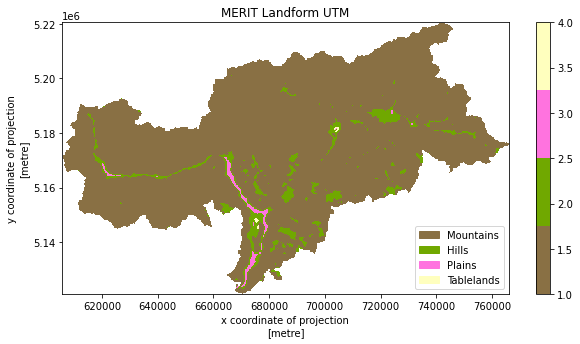

In [33]:
fig, ax = plt.subplots(figsize=(10,5))
fig = merit_landform_clipped[0].plot.imshow(ax=ax,cmap=cmap_landform,vmax=4, vmin=1)
ax.set_title("MERIT Landform UTM")
ax.legend(handles=legend,loc='lower right')
ax.margins(10)
plt.plot()

In [34]:
merit_landform_clipped[0].to_netcdf("merit_to_wte_lf_UTM_ST.nc")

Combine the NaN masks and mask the data to avoid not overlapping pixels due to reprojection:

In [35]:
na_mask = np.bitwise_not(np.bitwise_or(xr.ufuncs.isnan(wte_lf_UTM),xr.ufuncs.isnan(merit_landform_clipped)))
wte_lf_UTM_masked_merit = wte_lf_UTM.where(na_mask)
merit_to_wte_UTM_masked = merit_landform_clipped.where(na_mask)

[]

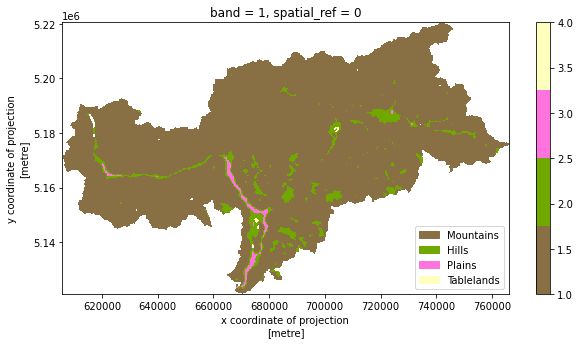

In [36]:
fig, ax = plt.subplots(figsize=(10,5))
fig = merit_to_wte_UTM_masked[0].plot.imshow(ax=ax,cmap=cmap_landform,vmax=4, vmin=1)
ax.legend(handles=legend,loc='lower right')
ax.margins(10)
plt.plot()

Now that we have both moisture layers with the same class scheme and projection we can compute the difference:

In [37]:
wte_merit_diff = wte_lf_UTM_masked_merit - merit_to_wte_UTM_masked

[]

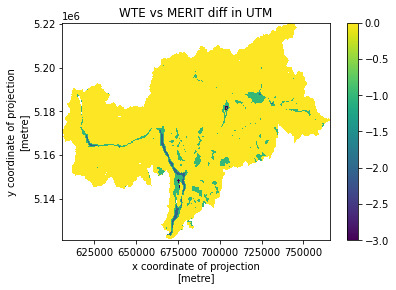

In [38]:
fig, ax = plt.subplots()
wte_merit_diff[0].plot.imshow(ax=ax)
ax.set_title("WTE vs MERIT diff in UTM")
plt.plot()

## DTM LIDAR

In [39]:
DTM_LIDAR = LANDFORM_FOLDER + "DTM_LIDAR_ST_EPSG3035_LAEA-EUROPE_250m_WTE_LF.tif"

In [40]:
lidar_landform = xr.open_rasterio(DTM_LIDAR)
lidar_landform

<xarray.DataArray (band: 1, y: 394, x: 642)>
[252948 values with dtype=uint16]
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 2.667e+06 2.666e+06 2.666e+06 ... 2.569e+06 2.568e+06
  * x        (x) float64 4.35e+06 4.351e+06 4.351e+06 ... 4.51e+06 4.511e+06
Attributes:
    transform:      (250.0, 0.0, 4350234.580151736, 0.0, -250.0, 2666796.2087...
    crs:            +init=epsg:3035
    res:            (250.0, 250.0)
    is_tiled:       0
    nodatavals:     (255.0,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area

Reprojection to 250m in UTM with mode interpolation

In [41]:
lidar_landform_clipped = lidar_landform.rio.reproject_match(wte_lf_UTM,6)
lidar_landform_clipped = lidar_landform_clipped.rio.clip(df.geometry, drop=True)
lidar_landform_clipped = lidar_landform_clipped.where(lidar_landform_clipped!=lidar_landform_clipped.attrs["_FillValue"])
lidar_landform_clipped.attrs["_FillValue"] = np.nan

[]

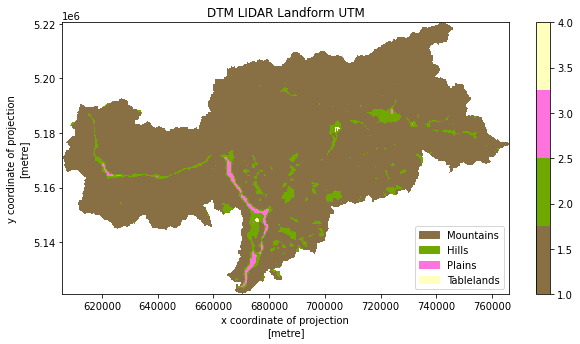

In [42]:
fig, ax = plt.subplots(figsize=(10,5))
fig = lidar_landform_clipped[0].plot.imshow(ax=ax,cmap=cmap_landform,vmax=4, vmin=1)
ax.set_title("DTM LIDAR Landform UTM")
ax.legend(handles=legend,loc='lower right')
ax.margins(10)
plt.plot()

In [43]:
# lidar_landform_clipped[0].to_netcdf("lidar_to_wte_lf_UTM_ST.nc")

Combine the NaN masks and mask the data to avoid not overlapping pixels due to reprojection:

In [44]:
na_mask = np.bitwise_not(np.bitwise_or(xr.ufuncs.isnan(wte_lf_UTM),xr.ufuncs.isnan(lidar_landform_clipped)))
wte_lf_UTM_masked_lidar = wte_lf_UTM.where(na_mask)
lidar_to_wte_UTM_masked = lidar_landform_clipped.where(na_mask)

Now that we have both moisture layers with the same class scheme and projection we can compute the difference:

In [45]:
wte_lidar_diff = wte_lf_UTM_masked_lidar - lidar_to_wte_UTM_masked

[]

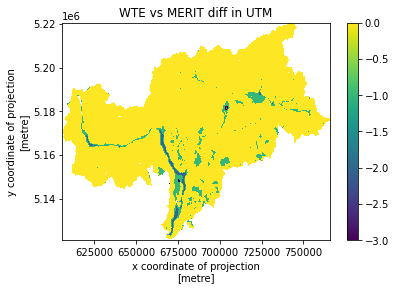

In [46]:
fig, ax = plt.subplots()
wte_lidar_diff[0].plot.imshow(ax=ax)
ax.set_title("WTE vs MERIT diff in UTM")
plt.plot()

Compute the difference between the regional EURAC layer with the global ones

In [47]:
#EURAC vs SRTM:
na_mask = np.bitwise_not(np.bitwise_or(xr.ufuncs.isnan(lidar_landform_clipped[0]),xr.ufuncs.isnan(srtm_landform_clipped[0])))
srtm_to_wte_UTM_masked = srtm_landform_clipped[0].where(na_mask)
eurac_to_wte_UTM_masked     = lidar_landform_clipped.where(na_mask).drop('band')
eurac_srtm_diff = eurac_to_wte_UTM_masked - srtm_to_wte_UTM_masked
#EURAC vs MERIT:
na_mask = np.bitwise_not(np.bitwise_or(xr.ufuncs.isnan(lidar_landform_clipped[0]),xr.ufuncs.isnan(merit_landform_clipped[0])))
merit_to_wte_UTM_masked = merit_landform_clipped[0].where(na_mask)
eurac_to_wte_UTM_masked  = lidar_landform_clipped.where(na_mask).drop('band')
eurac_merit_diff = eurac_to_wte_UTM_masked - merit_to_wte_UTM_masked

Table resuming the correspondence between the data
1. Compute the number of pixels which are non zero
2. Compute the percentage and the area in km^2 of the difference

In [48]:
#WTE vs SRTM:
wte_srtm_diff_km2 = np.count_nonzero(wte_srtm_diff.fillna(0).astype(np.int8)) * (0.25**2) #Area in km^2
wte_srtm_diff_dis = np.count_nonzero(wte_srtm_diff.fillna(0))/np.count_nonzero(~np.isnan(wte_srtm_diff))*100 #Percentage of disagreement
#WTE vs MERIT:
wte_merit_diff_km2 = np.count_nonzero(wte_merit_diff.fillna(0).astype(np.int8)) * (0.25**2) #Area in km^2
wte_merit_diff_dis = np.count_nonzero(wte_merit_diff.fillna(0))/np.count_nonzero(~np.isnan(wte_merit_diff))*100 #Percentage of disagreement
#WTE vs LIDARC:
wte_lidar_diff_km2 = np.count_nonzero(wte_lidar_diff.fillna(0).astype(np.int8)) * (0.25**2) #Area in km^2
wte_lidar_diff_dis = np.count_nonzero(wte_lidar_diff.fillna(0))/np.count_nonzero(~np.isnan(wte_lidar_diff))*100 #Percentage of disagreement
#LIDAR vs SRTM:
eurac_srtm_diff_km2 = np.count_nonzero(eurac_srtm_diff.fillna(0).astype(np.int8)) * (0.25**2) #Area in km^2
eurac_srtm_diff_dis = np.count_nonzero(eurac_srtm_diff.fillna(0))/np.count_nonzero(~np.isnan(eurac_srtm_diff))*100 #Percentage of disagreement
#LIDAR vs MERIT:
eurac_merit_diff_km2 = np.count_nonzero(eurac_merit_diff.fillna(0).astype(np.int8)) * (0.25**2) #Area in km^2
eurac_merit_diff_dis = np.count_nonzero(eurac_merit_diff.fillna(0))/np.count_nonzero(~np.isnan(eurac_merit_diff))*100 #Percentage of disagreement

In [49]:
import pandas as pd

data = {'Disagreement [km^2]':  [wte_srtm_diff_km2, wte_merit_diff_km2,wte_lidar_diff_km2,eurac_srtm_diff_km2,eurac_merit_diff_km2],
        'Disagreement [%]': [wte_srtm_diff_dis, wte_merit_diff_dis,wte_lidar_diff_dis,eurac_srtm_diff_dis,eurac_merit_diff_dis],
        }

df = pd.DataFrame(data, columns = ['Disagreement [km^2]','Disagreement [%]'], index=['WTE vs SRTM','WTE vs MERIT','WTE vs LIDAR DTM','LIDAR DTM vs SRTM','LIDAR DTM vs MERIT'])

df

,Disagreement [km^2],Disagreement [%]
WTE vs SRTM,463.5625,6.288631
WTE vs MERIT,471.1250,6.391223
WTE vs LIDAR DTM,464.7500,6.296466
LIDAR DTM vs SRTM,104.2500,1.412889
LIDAR DTM vs MERIT,96.1875,1.303619


In [50]:
def plot_confusion_matrix(ax, cm, labels, normalize=True, cmap='Blues',true="WTE",predicted="predicted"):
    """Plot the confusion matrix ``cm``.
    Parameters
    ----------
    cm : :py:class:`numpy.ndarray`
        The confusion matrix.
    labels : `list` [`str`]
        Names of the classes.
    normalize : `bool`, optional
        Whether to normalize the confusion matrix. The default is `True`.
    figsize : `tuple` [`int`], optional
        The figure size in centimeters. The default is `(10, 10)`.
    cmap : `str`, optional
        A matplotlib colormap. The default is `'Blues'`.
    Returns
    -------
    fig : :py:class:`matplotlib.figure.Figure`
        An instance of :py:class:`matplotlib.figure.Figure`.
    ax : :py:class:`matplotlib.axes._subplots.AxesSubplot`
        An instance of :py:class:`matplotlib.axes._subplots.AxesSubplot`.
    """
    # number of classes
    nclasses = len(labels)

    # string format to plot values of confusion matrix
    fmt = '.0f'

    # minimum and maximum values of the colorbar
    vmin, vmax = 0, cm.max()

    # check whether to normalize the confusion matrix
    if normalize:
        # normalize
        norm = cm.sum(axis=1, keepdims=True)

        # check for division by zero
        norm[norm == 0] = 1
        cm = cm / norm

        # change string format to floating point
        fmt = '.2f'
        vmin, vmax = 0, 1

    # get colormap
    cmap = colormap.get_cmap(cmap, 256)

    # plot confusion matrix
    im = ax.imshow(cm, cmap=cmap, vmin=vmin, vmax=vmax)

    # threshold determining the color of the values
    thresh = (cm.max() + cm.min()) / 2

    # brightest/darkest color of current colormap
    cmap_min, cmap_max = cmap(0), cmap(256)

    # plot values of confusion matrix
    for i, j in itertools.product(range(nclasses), range(nclasses)):
        ax.text(j, i, format(cm[i, j], fmt), ha='center', va='center', color=cmap_max if cm[i, j] < thresh else cmap_min)

    # axes properties and labels
    ax.set(xticks=np.arange(nclasses),yticks=np.arange(nclasses),xticklabels=labels,yticklabels=labels,ylabel=true,xlabel=predicted)

    # rotate x-tick labels
    for label in ax.get_xticklabels():
        label.set_rotation(90)

    return


[]

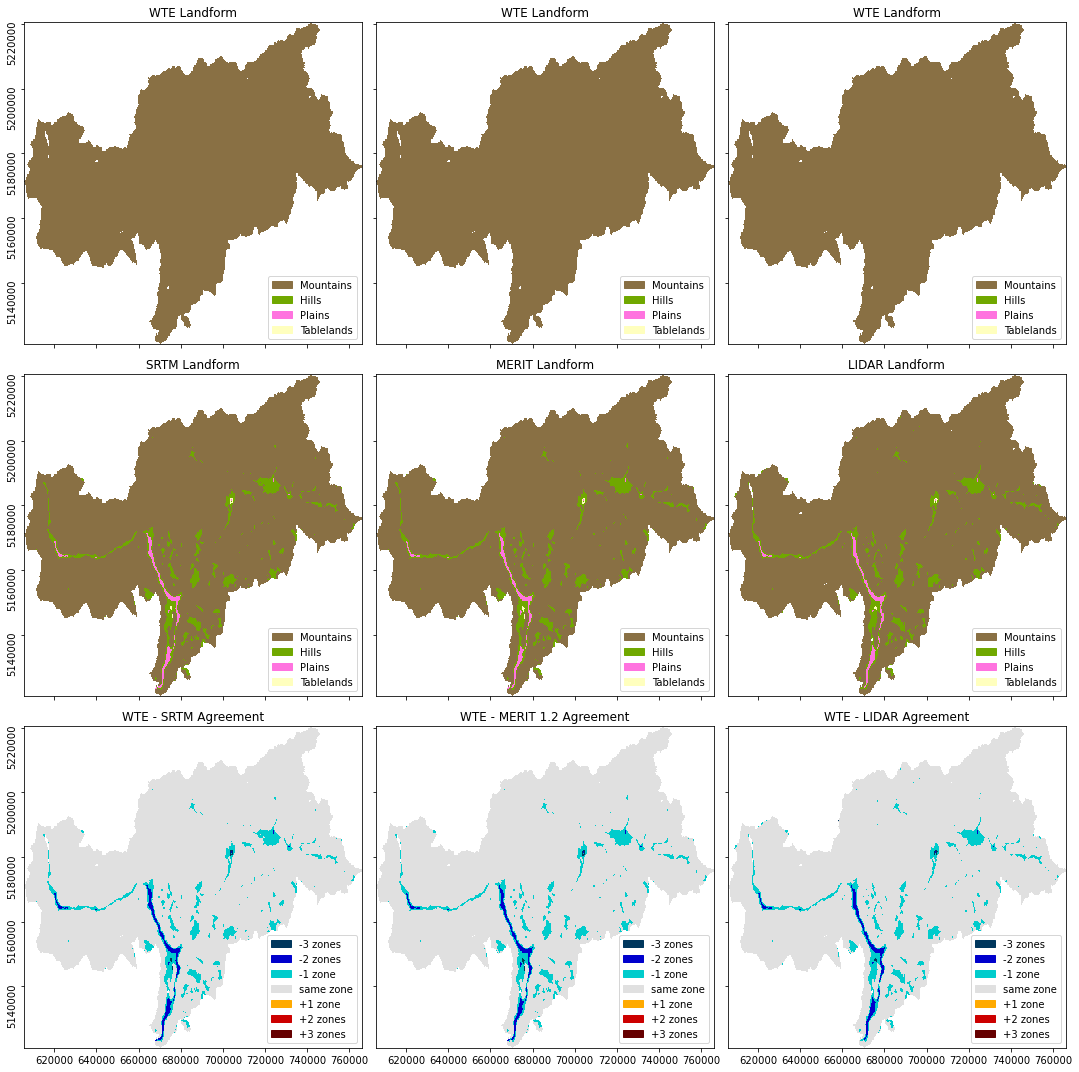

In [57]:
axis_xmin = wte_lf_UTM_masked_srtm.x.min().values
axis_ymin = wte_lf_UTM_masked_srtm.y.min().values
axis_xmax = wte_lf_UTM_masked_srtm.x.max().values
axis_ymax = wte_lf_UTM_masked_srtm.y.max().values

landform_labels     = ['Mountains','Hills','Plains','Tablelands']

fig, ax = plt.subplots(3,3,figsize=(15,15))
fig = wte_lf_UTM_masked_srtm[0].plot.imshow(ax=ax[0,0],cmap=cmap_landform,vmax=4, vmin=1,add_colorbar=False)
ax[0,0].set_title("WTE Landform")
ax[0,0].legend(handles=legend,loc='lower right')
fig = wte_lf_UTM_masked_merit[0].plot.imshow(ax=ax[0,1],cmap=cmap_landform,vmax=4, vmin=1,add_colorbar=False)
ax[0,1].set_title("WTE Landform")
ax[0,1].legend(handles=legend,loc='lower right')
fig = wte_lf_UTM_masked_lidar[0].plot.imshow(ax=ax[0,2],cmap=cmap_landform,vmax=4, vmin=1,add_colorbar=False)
ax[0,2].set_title("WTE Landform")
ax[0,2].legend(handles=legend,loc='lower right')

fig = srtm_to_wte_UTM_masked.plot.imshow(ax=ax[1,0],cmap=cmap_landform,vmax=4, vmin=1,add_colorbar=False)
ax[1,0].set_title("SRTM Landform")
ax[1,0].legend(handles=legend,loc='lower right')
fig = merit_to_wte_UTM_masked.plot.imshow(ax=ax[1,1],cmap=cmap_landform,vmax=4, vmin=1,add_colorbar=False)
ax[1,1].set_title("MERIT Landform")
ax[1,1].legend(handles=legend,loc='lower right')
fig = lidar_to_wte_UTM_masked[0].plot.imshow(ax=ax[1,2],cmap=cmap_landform,vmax=4, vmin=1,add_colorbar=False)
ax[1,2].set_title("LIDAR Landform")
ax[1,2].legend(handles=legend,loc='lower right')

fig = wte_srtm_diff[0].plot.imshow(ax=ax[2,0],cmap=diff_cmap,vmax=3, vmin=-3,add_colorbar=False)
ax[2,0].set_title("WTE - SRTM Agreement")
ax[2,0].legend(handles=legend_diff,loc='lower right')
fig = wte_merit_diff[0].plot.imshow(ax=ax[2,1],cmap=diff_cmap,vmax=3, vmin=-3,add_colorbar=False)
ax[2,1].set_title("WTE - MERIT 1.2 Agreement")
ax[2,1].legend(handles=legend_diff,loc='lower right')
fig = wte_lidar_diff[0].plot.imshow(ax=ax[2,2],cmap=diff_cmap,vmax=3, vmin=-3,add_colorbar=False)
ax[2,2].set_title("WTE - LIDAR Agreement")
ax[2,2].legend(handles=legend_diff,loc='lower right')
        
# rotate y-tick labels
for i in ax[:3]:
    for k in i[:]:
        for label in k.get_yticklabels():
            label.set_rotation(90)
    
# remove all axis labels
for i in ax[:3]:
    for k in i[:]:
        k.set_xlabel("")
        k.set_ylabel("")  
        k.ticklabel_format(style='plain')
for i in ax[:2]:
    for k in i[:]:
        for i, tick in enumerate(k.xaxis.get_ticklabels()):
            tick.set_visible(False)
for i in ax[:]:
    for k in i[1:]:
        for i, tick in enumerate(k.yaxis.get_ticklabels()):
            tick.set_visible(False)

plt.tight_layout()
plt.plot()

[]

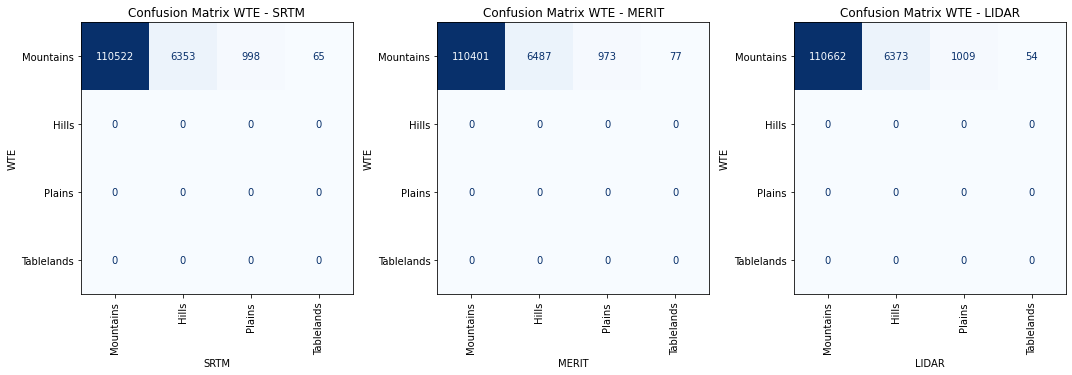

In [58]:
landform_labels     = ['Mountains','Hills','Plains','Tablelands']

fig, ax = plt.subplots(1,3,figsize=(15,20))
     
cm_cgiar = confusion_matrix(wte_lf_UTM_masked_srtm[0].fillna(-999).values.flatten(), srtm_to_wte_UTM_masked.fillna(-999).values.flatten(), labels=[-999,1,2,3,4])
cm_cgiar = cm_cgiar[1:,1:]
plot_confusion_matrix(ax[0],cm_cgiar,[1,2,3,4],true="WTE",predicted="SRTM",normalize=None)
ax[0].set_xticklabels(landform_labels)
ax[0].set_yticklabels(landform_labels)
ax[0].set_title("Confusion Matrix WTE - SRTM")

cm_chelsa = confusion_matrix(wte_lf_UTM_masked_merit[0].fillna(-999).values.flatten(), merit_to_wte_UTM_masked.fillna(-999).values.flatten(), normalize=None, labels=[-999,1,2,3,4])
cm_chelsa = cm_chelsa[1:,1:]
plot_confusion_matrix(ax[1],cm_chelsa,[1,2,3,4],true="WTE",predicted="MERIT",normalize=None)
ax[1].set_xticklabels(landform_labels)
ax[1].set_yticklabels(landform_labels)
ax[1].set_title("Confusion Matrix WTE - MERIT")

cm_eurac = confusion_matrix(wte_lf_UTM_masked_lidar.fillna(-999).values.flatten(), lidar_to_wte_UTM_masked.fillna(-999).values.flatten(), normalize=None, labels=[-999,1,2,3,4])
cm_eurac = cm_eurac[1:,1:]
plot_confusion_matrix(ax[2],cm_eurac,[1,2,3,4],true="WTE",predicted="LIDAR",normalize=None)
ax[2].set_xticklabels(landform_labels)
ax[2].set_yticklabels(landform_labels)
ax[2].set_title("Confusion Matrix WTE - LIDAR")

plt.tight_layout()
plt.plot()